<a href="https://colab.research.google.com/github/Danazzz/dataset-beras-scm/blob/main/SCM_Beras1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# Import libraries
import pandas as pd
import zipfile, os
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VAR

import xgboost

In [40]:
# Specify the path to your CSV file
file_path1 = '/Users/danawardhiana/Projects/dataset-beras/export-produsen-2-2.csv'
file_path2 = '/Users/danawardhiana/Projects/dataset-beras/Tabel Harga Berdasarkan Daerah Jabar.csv'

# Use pandas to read the CSV file
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Now 'data' is a pandas DataFrame containing the data from the CSV file

In [41]:
#Load data BI
converters = {
    'Beras': lambda x: str(x.replace(',', '')),
    'Beras Kualitas Bawah I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Medium I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Super I' : lambda x: str(x.replace(',', '')),
}

df1 = pd.read_csv('Tabel Harga Berdasarkan Daerah Jabar.csv', converters=converters)
df1

,Komoditas,Beras,Beras Kualitas Bawah I,Beras Kualitas Bawah II,Beras Kualitas Medium I,Beras Kualitas Medium II,Beras Kualitas Super I,Beras Kualitas Super II
0,01/ 01/ 2020,-,-,-,-,-,-,-
1,02/ 01/ 2020,11150,10100,"9,500",11350,"10,850",12900,"12,100"
2,03/ 01/ 2020,11150,10100,"9,500",11350,"10,850",12900,"12,100"
3,06/ 01/ 2020,11150,10150,"9,550",11350,"10,850",12900,"12,100"
4,07/ 01/ 2020,11200,10200,"9,650",11400,"10,900",12950,"12,150"
...,...,...,...,...,...,...,...,...
1093,11/ 03/ 2024,15800,14950,"14,500",16050,"15,550",17250,"16,550"
1094,12/ 03/ 2024,15800,14950,"14,500",16050,"15,550",17250,"16,550"
1095,13/ 03/ 2024,15750,14900,"14,400",16000,"15,450",17200,"16,550"
1096,14/ 03/ 2024,15750,14900,"14,400",16000,"15,450",17200,"16,550"


In [42]:
print('Data Types:')
print(df1.dtypes)

Data Types:
Komoditas                   object
Beras                       object
Beras Kualitas Bawah I      object
Beras Kualitas Bawah II     object
Beras Kualitas Medium I     object
Beras Kualitas Medium II    object
Beras Kualitas Super I      object
Beras Kualitas Super II     object
dtype: object


In [43]:
#Mengubah tanggal menjadi index
con=df1['Komoditas']
df1['Komoditas'] = pd.to_datetime(df1['Komoditas'], format='%d/ %m/ %Y')
df1.set_index('Komoditas', inplace=True)
#check datatype of index
df1.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07',
               '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1098, freq=None)

In [44]:
df1 = df1.iloc[:, [0, 1, 3, 5]]
df1

,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,
2020-01-01,-,-,-,-
2020-01-02,11150,10100,11350,12900
2020-01-03,11150,10100,11350,12900
2020-01-06,11150,10150,11350,12900
2020-01-07,11200,10200,11400,12950
...,...,...,...,...
2024-03-11,15800,14950,16050,17250
2024-03-12,15800,14950,16050,17250
2024-03-13,15750,14900,16000,17200


In [45]:
# Mengubah - menjadi 0
df1.replace('-', np.nan, inplace=True)
df1

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_10420/3795684999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('-', np.nan, inplace=True)


,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,11150,10100,11350,12900
2020-01-03,11150,10100,11350,12900
2020-01-06,11150,10150,11350,12900
2020-01-07,11200,10200,11400,12950
...,...,...,...,...
2024-03-11,15800,14950,16050,17250
2024-03-12,15800,14950,16050,17250
2024-03-13,15750,14900,16000,17200


In [46]:
df1 = df1.astype('Int64')
df1

,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,
2020-01-01,<NA>,<NA>,<NA>,<NA>
2020-01-02,11150,10100,11350,12900
2020-01-03,11150,10100,11350,12900
2020-01-06,11150,10150,11350,12900
2020-01-07,11200,10200,11400,12950
...,...,...,...,...
2024-03-11,15800,14950,16050,17250
2024-03-12,15800,14950,16050,17250
2024-03-13,15750,14900,16000,17200


In [47]:
df1.info()
df1.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2020-01-01 to 2024-03-15
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Beras                    1050 non-null   Int64
 1   Beras Kualitas Bawah I   1050 non-null   Int64
 2   Beras Kualitas Medium I  1050 non-null   Int64
 3   Beras Kualitas Super I   1050 non-null   Int64
dtypes: Int64(4)
memory usage: 47.2 KB


(1098, 4)

In [48]:
converters = {
    'Luas Panen Padi': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Petani': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'GKG Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Medium Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Premium Penggilingan' : lambda x: str(x.replace('.', '')),
}

#Load data
df2 = pd.read_csv('export-produsen-2-2.csv', converters=converters)
# print(df2.head())
df2

,Komoditas,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Jagung Pipilan Kering,Kedelai Biji Kering (Lokal),Bawang Merah,Cabai Merah Keriting,Cabai Rawit Merah,Sapi (Hidup),Ayam Ras Pedaging (Hidup),Telur Ayam Ras,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
0,01/01/2020,20,3700,4000,4500,8200,9200,-,-,-,-,-,-,-,-,600,150
1,02/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,03/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,04/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,05/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,11/03/2024,10,6760,7140,8330,14180,15640,5.540,10.610,15.990,41.880,45.050,54.440,24.480,27.540,120,80
1532,12/03/2024,10,6530,6930,8260,14140,15480,5.250,10.610,16.330,42.830,43.390,54.470,24.480,28.260,120,80
1533,13/03/2024,10,6480,6920,8240,14040,15460,5.280,10.310,15.990,43.770,42.270,54.560,24.000,28.200,100,60
1534,14/03/2024,10,6510,7060,8240,14050,15510,5.280,10.310,15.840,45.070,41.840,54.550,24.010,28.130,150,70


PRODUSEN
Panel Harga Pangan pada tingkat produsen yang diamati meliputi:
- Luas Lahan/Sawah Padi, persentase (%) luas panen Padi di kecamatan sentra produksi.
- GKP Tingkat Petani, harga di Petani (Rp/Kg)
- GKP Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- GKG Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Medium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Premium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Stok GKG Tingkat Penggilingan, stok dalam satuan Kwintal
- Stok Beras Tingkat Penggilingan, stok dalam satuan Kwintal

In [49]:
print('Data Types:')
print(df2.dtypes)

Data Types:
Komoditas                          object
Luas Panen Padi                    object
GKP Tingkat Petani                 object
GKP Tingkat Penggilingan           object
GKG Tingkat Penggilingan           object
Beras Medium Penggilingan          object
Beras Premium Penggilingan         object
Jagung Pipilan Kering              object
Kedelai Biji Kering (Lokal)        object
Bawang Merah                       object
Cabai Merah Keriting               object
Cabai Rawit Merah                  object
Sapi (Hidup)                       object
Ayam Ras Pedaging (Hidup)          object
Telur Ayam Ras                     object
Stok GKG Tingkat Penggilingan      object
Stok Beras Tingkat Penggilingan    object
dtype: object


In [50]:
#Mengubah tanggal menjadi index
con=df2['Komoditas']
df2['Komoditas'] = pd.to_datetime(df2['Komoditas'], format='%d/%m/%Y')
df2.set_index('Komoditas', inplace=True)
#check datatype of index
df2.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1536, freq=None)

In [51]:
df2 = df2.iloc[:, [0, 1, 2, 3, 4, 5, 14, 15]]
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150
2020-01-02,-,-,-,-,-,-,-,-
2020-01-03,-,-,-,-,-,-,-,-
2020-01-04,-,-,-,-,-,-,-,-
2020-01-05,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80
2024-03-12,10,6530,6930,8260,14140,15480,120,80
2024-03-13,10,6480,6920,8240,14040,15460,100,60


In [52]:
# Mengubah - menjadi 0
df2.replace('-', np.nan, inplace=True)
df2

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_10420/1373517859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('-', np.nan, inplace=True)


,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80
2024-03-12,10,6530,6930,8260,14140,15480,120,80
2024-03-13,10,6480,6920,8240,14040,15460,100,60


In [53]:
# ini datanya ada yang gajelas 1
# luas panen 20710?
result = df2[df2['Luas Panen Padi'] == '20710']
print(result)

           Luas Panen Padi GKP Tingkat Petani GKP Tingkat Penggilingan  \
Komoditas                                                                
2021-03-12           20710              20710                    20710   

           GKG Tingkat Penggilingan Beras Medium Penggilingan  \
Komoditas                                                       
2021-03-12                    20710                     20710   

           Beras Premium Penggilingan Stok GKG Tingkat Penggilingan  \
Komoditas                                                             
2021-03-12                      20710                           NaN   

           Stok Beras Tingkat Penggilingan  
Komoditas                                   
2021-03-12                             NaN  


In [54]:
df2 = df2.astype('Int64')
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80
2024-03-12,10,6530,6930,8260,14140,15480,120,80
2024-03-13,10,6480,6920,8240,14040,15460,100,60


In [55]:
df2.info()
df2.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1536 entries, 2020-01-01 to 2024-03-15
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1073 non-null   Int64
 1   GKP Tingkat Petani               1074 non-null   Int64
 2   GKP Tingkat Penggilingan         1074 non-null   Int64
 3   GKG Tingkat Penggilingan         1076 non-null   Int64
 4   Beras Medium Penggilingan        1076 non-null   Int64
 5   Beras Premium Penggilingan       1076 non-null   Int64
 6   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 7   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
dtypes: Int64(8)
memory usage: 120.0 KB


(1536, 8)

In [56]:
df3 = pd.merge(df2, df1, on='Komoditas', how='left')
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150,<NA>,<NA>,<NA>,<NA>
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,10100,11350,12900
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,10100,11350,12900
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80,15800,14950,16050,17250
2024-03-12,10,6530,6930,8260,14140,15480,120,80,15800,14950,16050,17250
2024-03-13,10,6480,6920,8240,14040,15460,100,60,15750,14900,16000,17200


In [57]:
df3.info()
df3.nunique()

# Menampilkan nilai unik dalam setiap kolom
for col in df3.columns:
    unique_values = df3[col].unique()
    print(f"Nilai unik dalam kolom {col}: {unique_values}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1536 entries, 2020-01-01 to 2024-03-15
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1073 non-null   Int64
 1   GKP Tingkat Petani               1074 non-null   Int64
 2   GKP Tingkat Penggilingan         1074 non-null   Int64
 3   GKG Tingkat Penggilingan         1076 non-null   Int64
 4   Beras Medium Penggilingan        1076 non-null   Int64
 5   Beras Premium Penggilingan       1076 non-null   Int64
 6   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 7   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
 8   Beras                            1050 non-null   Int64
 9   Beras Kualitas Bawah I           1050 non-null   Int64
 10  Beras Kualitas Medium I          1050 non-null   Int64
 11  Beras Kualitas Super I           1050 non-null   Int64
dtypes: Int64(12)
memory usage: 174

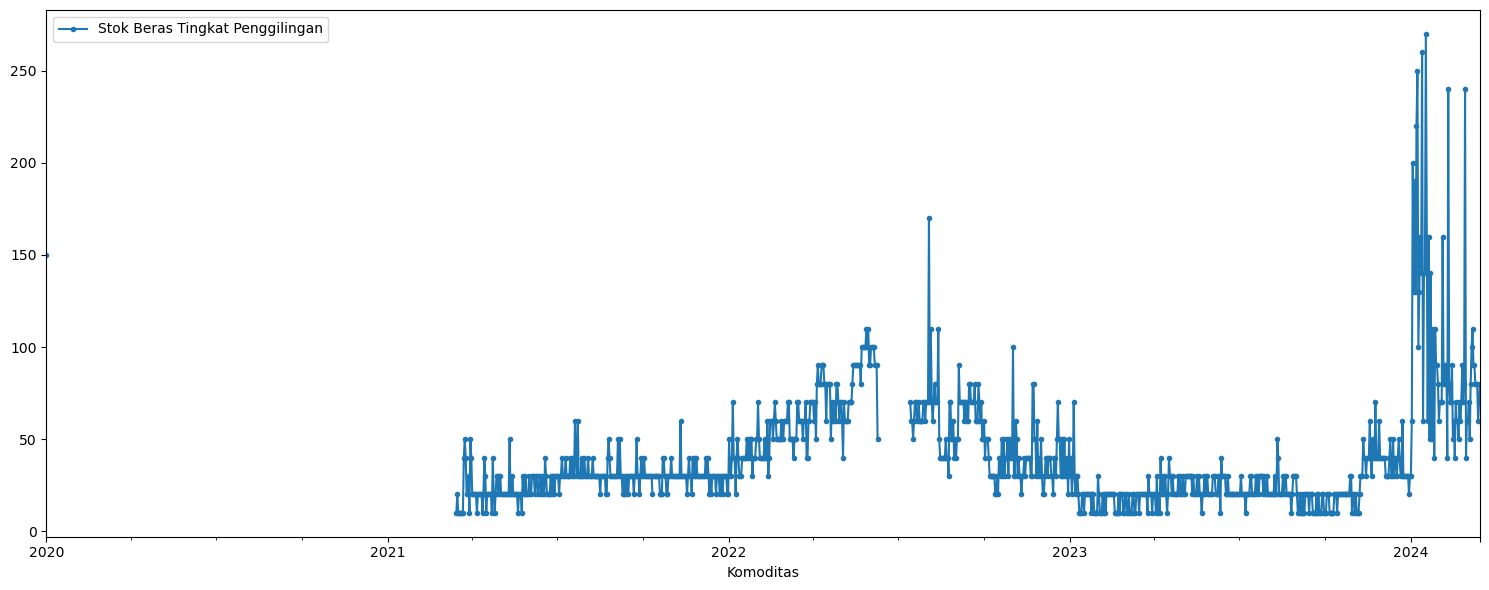

In [58]:
# plt.plot(df3)
df3[['Stok Beras Tingkat Penggilingan']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

In [59]:
# Clean dataset df3 from NaN
df3 = df3.dropna()
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,,,,,,,,,
2021-03-15,10,4000,4150,5050,8900,10030,20,10,11200,10100,11450,13100
2021-03-16,10,3850,4100,4740,8740,9980,70,20,11200,10100,11450,13100
2021-03-17,10,4160,4230,4950,8740,10060,30,10,11200,10100,11450,13100
2021-03-18,10,4120,4190,4730,8790,9890,40,10,11200,10050,11450,13100
2021-03-19,10,4190,4290,4990,8830,9990,40,10,11200,10100,11450,13100
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80,15800,14950,16050,17250
2024-03-12,10,6530,6930,8260,14140,15480,120,80,15800,14950,16050,17250
2024-03-13,10,6480,6920,8240,14040,15460,100,60,15750,14900,16000,17200


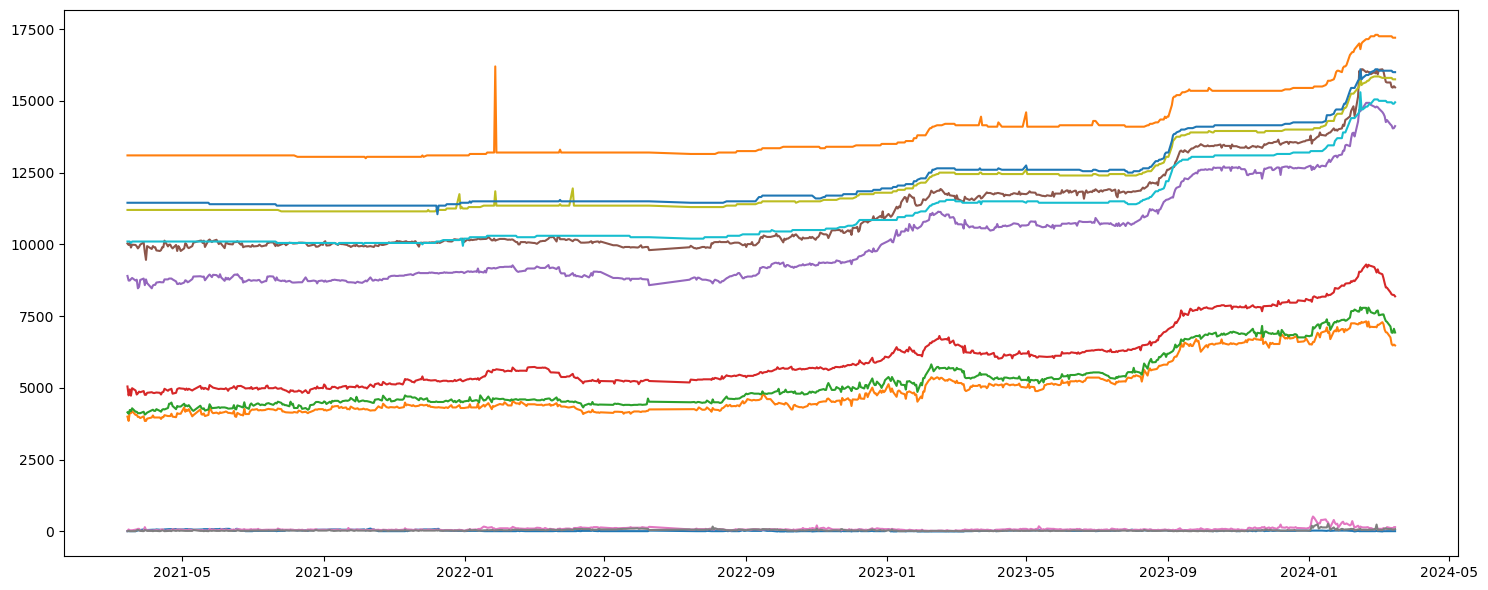

In [60]:
plt.plot(df3)
# df3[['GKP Tingkat Petani']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

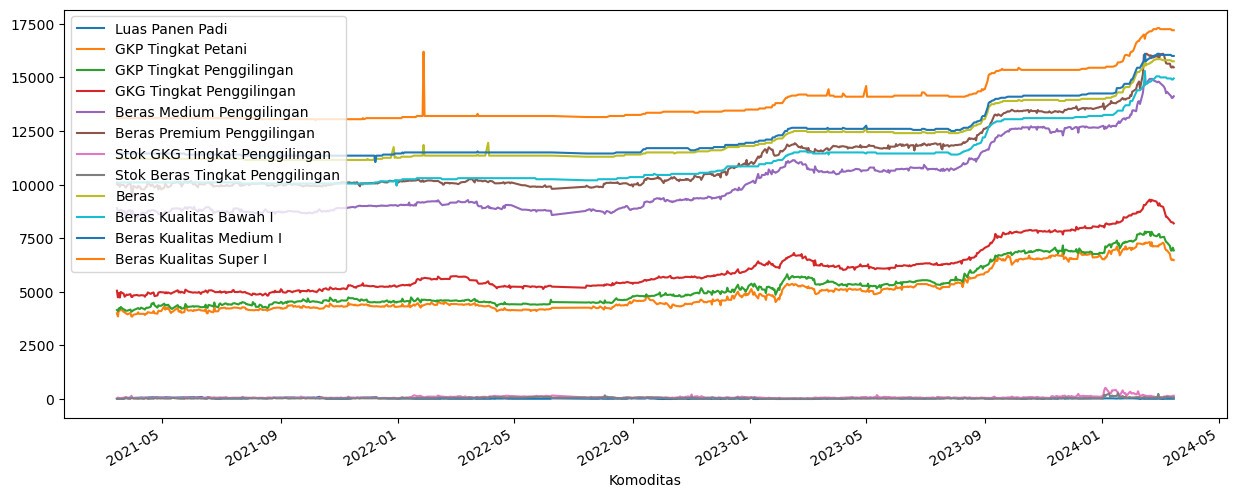

In [61]:
# Show me the column names of df3 in the plot above
df3.columns
import matplotlib.pyplot as plt

# Plot the dataframe
df3.plot()

# Show the column names
plt.legend(df3.columns)

# Display the plot
plt.show()


In [62]:
#is the dataset df3 ready for time series analysis?
df3.info()
df3.nunique()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2021-03-15 to 2024-03-15
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  733 non-null    Int64
 1   GKP Tingkat Petani               733 non-null    Int64
 2   GKP Tingkat Penggilingan         733 non-null    Int64
 3   GKG Tingkat Penggilingan         733 non-null    Int64
 4   Beras Medium Penggilingan        733 non-null    Int64
 5   Beras Premium Penggilingan       733 non-null    Int64
 6   Stok GKG Tingkat Penggilingan    733 non-null    Int64
 7   Stok Beras Tingkat Penggilingan  733 non-null    Int64
 8   Beras                            733 non-null    Int64
 9   Beras Kualitas Bawah I           733 non-null    Int64
 10  Beras Kualitas Medium I          733 non-null    Int64
 11  Beras Kualitas Super I           733 non-null    Int64
dtypes: Int64(12)
memory usage: 83.0

Luas Panen Padi                     11
GKP Tingkat Petani                 209
GKP Tingkat Penggilingan           226
GKG Tingkat Penggilingan           252
Beras Medium Penggilingan          240
Beras Premium Penggilingan         226
Stok GKG Tingkat Penggilingan       37
Stok Beras Tingkat Penggilingan     20
Beras                               65
Beras Kualitas Bawah I              69
Beras Kualitas Medium I             59
Beras Kualitas Super I              57
dtype: int64

In [78]:
#drop column Beras Kualitas Bawah I, Beras Kualitas Medium I, Beras Kualitas Super I
df3 = df3.drop(['Beras Kualitas Bawah I', 'Beras Kualitas Medium I', 'Beras Kualitas Super I'], axis=1)

In [79]:
import xgboost
import numpy as np

# List of features to predict
features = list(df3.columns)

# Dictionary to store models
models = {}

for feature in features:
    # Split the data into train and test sets
    train = df3[feature][:int(0.8*(len(df3)))]
    test = df3[feature][int(0.8*(len(df3))):]

    # Fit the XGBoost model
    model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(np.array(range(len(train))).reshape(-1, 1), train)

    # Store the model in the dictionary
    models[feature] = model

RMSE: 67.49274944564644


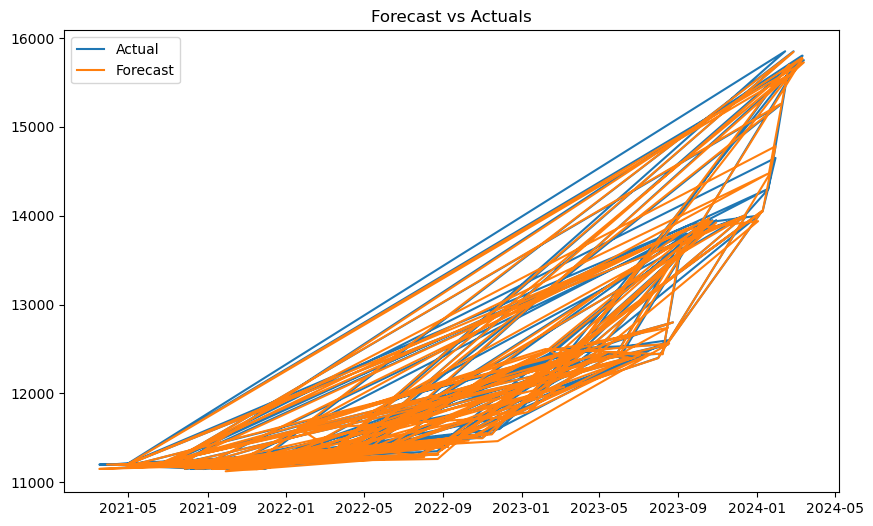

In [80]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and 'X_test' is your test features
# Forecast the future values

# Assuming 'df' is your original DataFrame and 'feature_cols' is a list of column names
X = df3.drop('Beras', axis=1) # This selects all columns except 'Beras'
y = df3['Beras']  # replace 'Beras' with your actual target column name

from sklearn.model_selection import train_test_split

# Assuming 'X' is your features and 'y' is your target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model on the training data
model.fit(X_train, y_train)

# Now you can use X_test
predictions = model.predict(X_test)

# Calculate the RMSE for each feature
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

# Dictionary to store the predictions
predictions_dict = {'forecast': predictions}

Feature: 0, Score: 0.00049
Feature: 1, Score: 0.11726
Feature: 2, Score: 0.08303
Feature: 3, Score: 0.33502
Feature: 4, Score: 0.08681
Feature: 5, Score: 0.37669
Feature: 6, Score: 0.00052
Feature: 7, Score: 0.00019


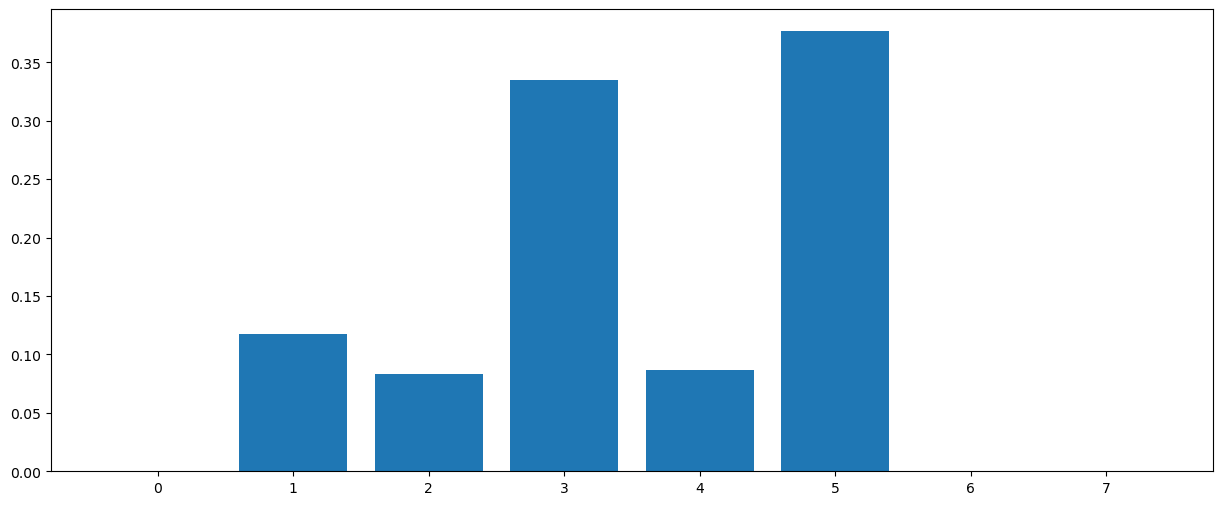

In [81]:
# Assuming 'model' is your trained XGBoost model and 'X' is your feature DataFrame
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [82]:
#which one is feature 0, 1, 2, 3, 4, 5, 6, 7?
X.columns

Index(['Luas Panen Padi', 'GKP Tingkat Petani', 'GKP Tingkat Penggilingan',
       'GKG Tingkat Penggilingan', 'Beras Medium Penggilingan',
       'Beras Premium Penggilingan', 'Stok GKG Tingkat Penggilingan',
       'Stok Beras Tingkat Penggilingan'],
      dtype='object')

In [83]:
#predict the future values of the features
X_future = df3.drop('Beras', axis=1).tail(10)
predictions = model.predict(X_future)
predictions

array([15800.   , 15800.   , 15799.998, 15800.001, 15800.   , 15776.886,
       15767.578, 15750.   , 15725.165, 15749.998], dtype=float32)

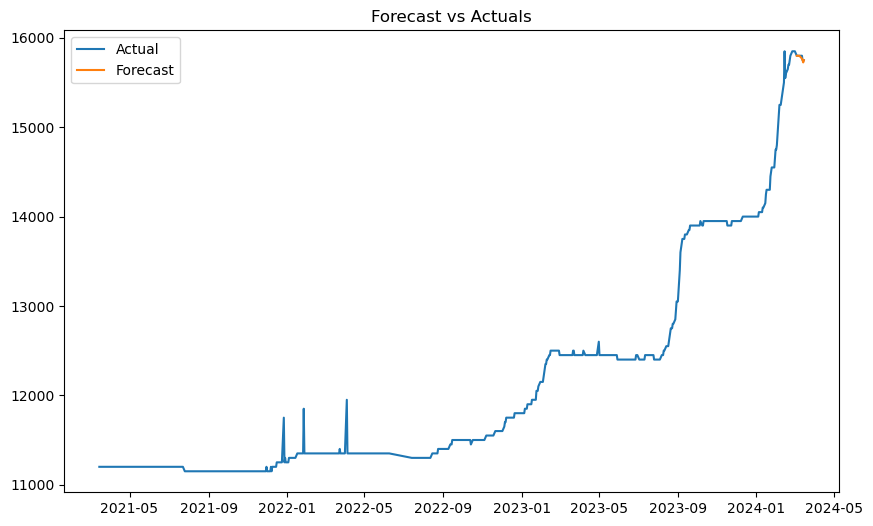

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras
Komoditas,,,,,,,,,
2024-03-04,0,7290,7560,8960,14610,16100,90,50,15800
2024-03-05,10,7220,7560,8820,14550,16020,120,80,15800
2024-03-06,10,7030,7430,8650,14460,15840,80,100,15800
2024-03-07,10,6940,7330,8500,14260,15660,80,110,15800
2024-03-08,10,6930,7300,8490,14330,15640,150,90,15800
2024-03-11,10,6760,7140,8330,14180,15640,120,80,15800
2024-03-12,10,6530,6930,8260,14140,15480,120,80,15800
2024-03-13,10,6480,6920,8240,14040,15460,100,60,15750
2024-03-14,10,6510,7060,8240,14050,15510,150,70,15750


In [86]:
#create a plot of the forecasted values (10 days into the future)
plt.figure(figsize=(10, 6))
plt.plot(df3['Beras'].index, df3['Beras'], label='Actual')
plt.plot(X_future.index, predictions, label='Forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

In [64]:
# from statsmodels.tsa.stattools import adfuller

# def check_stationarity(data, column_name):
#     # Calculate the rolling mean and rolling standard deviation
#     rolling_mean = df3['Beras'].rolling(window=12).mean()
#     rolling_std = df3['Beras'].rolling(window=12).std()
    
#     # Plot the rolling statistics
#     plt.plot(data[column_name], color='blue', label='Original Data')
#     plt.plot(rolling_mean, color='red', label='Rolling Mean')
#     plt.plot(rolling_std, color='black', label='Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Rolling Standard Deviation')
#     plt.show()
    
#     # Perform the Augmented Dickey-Fuller test
#     adf_test = adfuller(data[column_name])
#     print('Augmented Dickey-Fuller Test:')
#     print(f'ADF Statistic: {adf_test[0]}')
#     print(f'p-value: {adf_test[1]}')
#     print(f'Critical Values: {adf_test[4]}')
    
#     # Check if the data is stationary
#     if adf_test[1] <= 0.05:
#         print('Data is stationary')
#     else:
#         print('Data is not stationary')

# # Check if the data is stationary
# check_stationarity(df3, 'Beras')

In [65]:
# # Differencing
# df3['Beras_diff'] = df3['Beras'].diff()

# # Drop NA values
# df3 = df3.dropna()

# # Check if the data is now stationary
# check_stationarity(df3, 'Beras_diff')

In [66]:
# #okay now what ?
# # Autocorrelation and Partial Autocorrelation Plots
# plot_acf(df3['Beras_diff'])
# plt.show()


In [67]:
# #and then ?
# plot_pacf(df3['Beras_diff'])
# plt.show()

In [68]:
# # Split the data into training and testing sets
# train_size = int(len(df3) * 0.8)
# train, test = df3['Beras_diff'][:train_size], df3['Beras_diff'][train_size:]


In [69]:
# # Fit the XGBoost model
# model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
# model.fit(np.array(range(len(train))).reshape(-1, 1), train)

# # Make predictions
# predictions = model.predict(np.array(range(len(train), len(train) + len(test))).reshape(-1, 1))

# # Calculate the RMSE
# rmse = sqrt(mean_squared_error(test, predictions))
# print(f'RMSE: {rmse}')
# # Plot the predictions
# plt.plot(test.index, test, label='Actual Data')
# plt.plot(test.index, predictions, label='Predictions')
# plt.legend()
# plt.show()